# [Quora Question Pairs](https://www.kaggle.com/c/quora-question-pairs/overview)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/NaturalLanguageProcessing/kaggle/Quora_Question_Pairs

data  sentence-similarity-word2vec.ipynb


### 神经网络

In [3]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# 读取 CSV 文件并转成 Dataset
def load_dataset(path):
  data = pd.read_csv(path)
  return data # tf.data.Dataset.from_tensor_slices((x, y))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [4]:
TRAIN_FILE_PATH='/content/drive/MyDrive/NaturalLanguageProcessing/kaggle/Quora_Question_Pairs/data/train.csv'

# 读取文件
dataset = load_dataset(TRAIN_FILE_PATH)

In [5]:
dataset

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [7]:
# 2. download google word2vec pretrained embedding 

!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-05-27 11:35:31--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.80.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.80.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  44.1MB/s    in 37s     

2021-05-27 11:36:08 (42.9 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [9]:
from gensim.models import KeyedVectors

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [10]:
# 准备数据
question1 = dataset.question1.values
question2 = dataset.question2.values
label = np.array(dataset.is_duplicate.values)

In [11]:
question1[:4]

array(['What is the step by step guide to invest in share market in india?',
       'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
       'How can I increase the speed of my internet connection while using a VPN?',
       'Why am I mentally very lonely? How can I solve it?'], dtype=object)

In [12]:
question2[:4]

array(['What is the step by step guide to invest in share market?',
       'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?',
       'How can Internet speed be increased by hacking through DNS?',
       'Find the remainder when [math]23^{24}[/math] is divided by 24,23?'],
      dtype=object)

In [13]:
label[:4]

array([0, 0, 0, 0])

In [14]:
vec = word2vec.word_vec("test")
print(len(vec))

300


In [15]:
import spacy
nlp = spacy.load('en')

doc = nlp('Hello! My name is LittleTree!')
for token in doc:
    print(token.text)

Hello
!
My
name
is
LittleTree
!


In [16]:
from gensim.parsing.preprocessing import remove_stopwords
print(remove_stopwords('Hello! My name is LittleTree!'))

Hello! My LittleTree!


In [17]:
doc = nlp(remove_stopwords('Hello! My name is LittleTree!'))
for token in doc:
  if not token.is_punct:
    print(token.text)

Hello
My
LittleTree


In [62]:
data = []
for i in np.arange(10000): # len(question1) 404290
  tmp = np.zeros(300)
  for token in nlp(question1[i]):
    if not token.is_punct:
      try:
        tmp = tmp + word2vec.word_vec(token.text)
      except:
        pass
  for token in nlp(question2[i]):
    if not token.is_punct:
      try:
        tmp = tmp - word2vec.word_vec(token.text)
      except:
        pass
  data.append(np.array(tmp))

In [63]:
len(data[0])

300

In [64]:
data = np.array(data)

In [65]:
data.shape

(10000, 300)

In [66]:
# 划分训练集与测试集
train_vec, test_vec, train_labels, test_labels = train_test_split(data, label[:10000], test_size=0.2, random_state=42)

In [67]:
#
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [68]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [69]:
x_val = train_vec[:1500]
partial_x_train = train_vec[1500:]

y_val = train_labels[:1500]
partial_y_train = train_labels[1500:]

In [70]:
partial_x_train.shape

(6500, 300)

In [71]:
partial_y_train.shape

(6500,)

In [72]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 0.6324 - accuracy: 0.6163 - val_loss: 0.6005 - val_accuracy: 0.6393
Epoch 2/10
13/13 [==============================] - 0s 4ms/step - loss: 0.5727 - accuracy: 0.6626 - val_loss: 0.5903 - val_accuracy: 0.6553
Epoch 3/10
13/13 [==============================] - 0s 4ms/step - loss: 0.5416 - accuracy: 0.6838 - val_loss: 0.5857 - val_accuracy: 0.6747
Epoch 4/10
13/13 [==============================] - 0s 4ms/step - loss: 0.5145 - accuracy: 0.7286 - val_loss: 0.5736 - val_accuracy: 0.6740
Epoch 5/10
13/13 [==============================] - 0s 4ms/step - loss: 0.4926 - accuracy: 0.7605 - val_loss: 0.5737 - val_accuracy: 0.6780
Epoch 6/10
13/13 [==============================] - 0s 4ms/step - loss: 0.4710 - accuracy: 0.7732 - val_loss: 0.5706 - val_accuracy: 0.6900
Epoch 7/10
13/13 [==============================] - 0s 4ms/step - loss: 0.4490 - accuracy: 0.7985 - val_loss: 0.5705 - val_accuracy: 0.6900
Epoch 8/10
13/13 [=

In [73]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

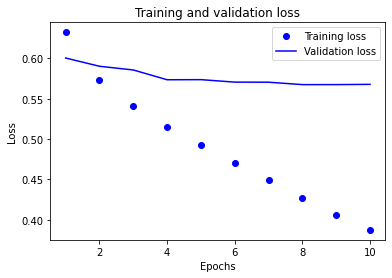

In [74]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

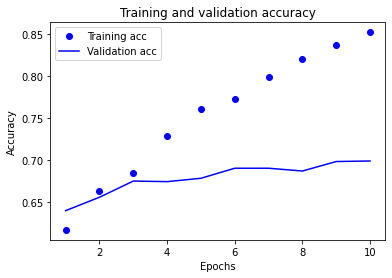

In [75]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [80]:
results = model.evaluate(test_vec, test_labels, batch_size=128)
print("test loss, test acc:", results)

16/16 [==============================] - 0s 2ms/step - loss: 0.5869 - accuracy: 0.6765
test loss, test acc: [0.586908757686615, 0.6765000224113464]
